In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
from torch import nn
from simulators import SimulatorBlob
from swyft.lightning.estimators import LogRatioEstimator_Autoregressive, LogRatioEstimator_Gaussian, LogRatioEstimator_Autoregressive_Gaussian

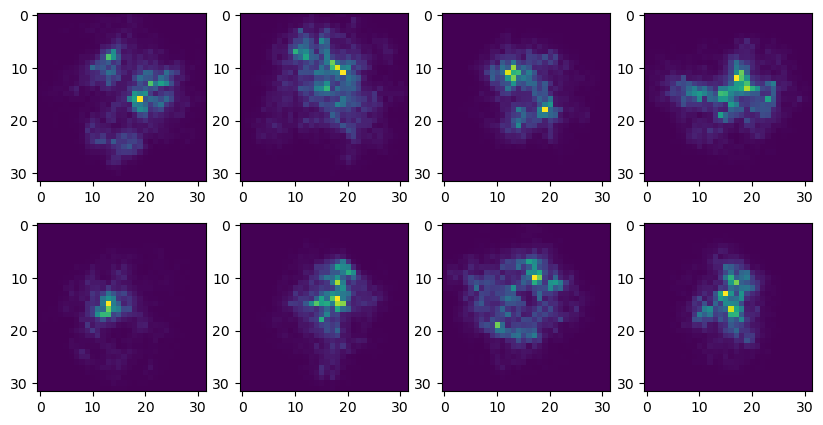

In [17]:
NPIX = 32

sim = SimulatorBlob(Npix = NPIX)
plt.figure(figsize = (10, 5))
for i in range(1, 9):
    plt.subplot(2, 4, i)
    sample = sim.sample()
    t = sample['mu']
    plt.imshow(t)
sample0 = sample

In [4]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, Npix = Npix):
        super().__init__()

        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.num_params = Npix**2
        self.lre = LogRatioEstimator_Autoregressive_Gaussian(Npix**2, "mu")
        self.l = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(1)
        )
        self.Npix = Npix

    def forward(self, A, B):
        x = A["mu"].view(-1, self.Npix**2)
        f = self.l(x.unsqueeze(-1)).squeeze(-1)
        result = self.lre(f, A['z'].view(-1, self.Npix**2), B['z'].view(-1, self.Npix**2))
        return result

In [34]:
def next_round(sample0, bounds = None, Nsims = 1024):
    sim = SimulatorBlob(bounds = bounds, Npix = NPIX)
    samples = sim.sample(Nsims)
    dl = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0], batch_size = 128)
    trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 100, precision = 32)
    network = Network(Npix = NPIX)
    trainer.fit(network, dl)
    Cov = sim.Cov.double().cuda()
    network.cuda()
    mu = torch.tensor(sample0['mu']).view(-1, sim.Npix**2)
    f = network.l(torch.tensor(mu).cuda().unsqueeze(-1)).squeeze(-1).detach()[0].cuda()
    draws = network.lre.get_samples(3, f, cov = Cov*1, gamma = 0.5).view(-1, sim.Npix, sim.Npix).cpu()
    return network, draws

In [35]:
bounds = None
for Nsims in [4096,]:
    network, draw = next_round(sample0, bounds = bounds, Nsims = Nsims)

  0%|          | 0/4096 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                      | Params
-------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Autoregressive_Gaussian | 2.1 M 
1 | l    | Sequential                                | 0     
-------------------------------------------------------------------
1.0 M     Trainable params
1.0 M     Non-trainable params
2.1 M     Total params
8.389     Total estimated model params s

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
/tmp/ipykernel_1949269/2968990252.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = network.l(torch.tensor(mu).cuda().unsqueeze(-1)).squeeze(-1).detach()[0].cuda()


tensor(-0.6101, device='cuda:0', dtype=torch.float64)


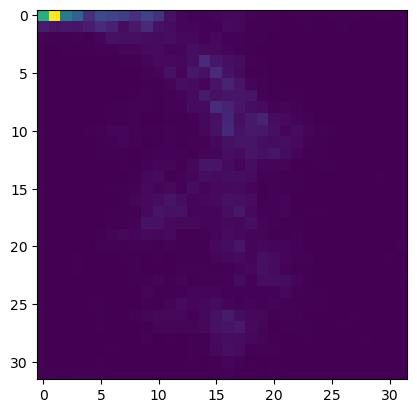

In [36]:
plt.imshow(np.exp(draw[1]))

In [37]:
Cov = sim.Cov.double().cuda()
network.cuda()
mu = torch.tensor(sample0['mu']).view(-1, sim.Npix**2)
f = network.l(torch.tensor(mu).cuda().unsqueeze(-1)).squeeze(-1).detach()[0].cuda()
draws = network.lre.get_samples(3, f, cov = Cov*1, gamma = 0.5).view(-1, sim.Npix, sim.Npix).cpu()

/tmp/ipykernel_1949269/2708887801.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = network.l(torch.tensor(mu).cuda().unsqueeze(-1)).squeeze(-1).detach()[0].cuda()


tensor(-0.6101, device='cuda:0', dtype=torch.float64)


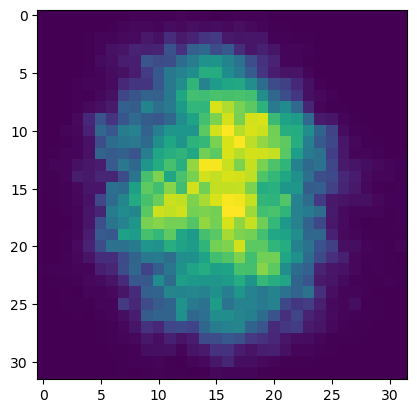

In [46]:
plt.imshow(f.view(32, 32).cpu().detach())